<a href="https://colab.research.google.com/github/vsnupoudel/CourseAssignment/blob/master/EDA_Ds_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and preprocessing the data
Direct download from Google Drive. 

In [1]:
!gdown --id 18dan1-qtEG-9NXF1nIw1il79gp77lB9a -O Data.zip

Downloading...
From: https://drive.google.com/uc?id=18dan1-qtEG-9NXF1nIw1il79gp77lB9a
To: /content/Data.zip
4.52MB [00:00, 23.7MB/s]


In [2]:
!unzip -o -q /content/Data.zip -d /content/data/  

In [3]:
INPUTS_DIR = '/content/data/Document_Dataset/inputs'
TEMPLATES_DIR = '/content/data/Document_Dataset/templates'

# Will attempt two methods
## Use algorithms that detect similarity of images
1. Crop the heading part of images 
2. Find a pretrained feature vector online on tfhub.dev or other sources.Take
3. Run these pretrained feature vectors on all the templates ( training data) , and store them.
4. Take any input from the input folder ( test set), get its feature vectors.
5. Using distance metric like Euclidean, Manhattan to find which image in template is nearest to the Input

## Use Doc2vec algorithm after extracting text using OCR API.
1. Two documents which have the most similar Doc2Vec embeddings are the same documents

# Trying the second algorithm, as it seems to do a better job from what I know.

## Storing documents' names in a dictionary, leaving their embeddings as None for now

In [4]:
import os
length, filenames  = len( os.listdir(TEMPLATES_DIR) ) , os.listdir(TEMPLATES_DIR) 

In [5]:
template_store = { key: { } for key in  filenames}      
template_store

{'document-000-113188.in.000.png': {},
 'document-000-113660.out.000.png': {},
 'document-000-118454.out.000.png': {},
 'document-000-123542.out.000.png': {},
 'document-001-110866.in.000.png': {},
 'document-001-113309.in.000.png': {},
 'document-001-113760.in.000.png': {},
 'document-001-114898.in.000.png': {},
 'document-001-115484.out.000.png': {},
 'document-001-118758.in.000.png': {},
 'document-001-123663.in.000.png': {},
 'document-002-110935.in.000.png': {},
 'document-002-114195.out.000.png': {},
 'document-003-112107.out.000.png': {},
 'document-004-112180.in.000.png': {},
 'document-004-114466.out.000.png': {},
 'document-004-115864.out.000.png': {},
 'document-005-118279.in.000.png': {},
 'document-006-101162.in.000.png': {},
 'document-006-118355.out.000.png': {}}

## Use OCR API to get text from Images
- Let us explore some of the images first

In [6]:
from PIL import Image  
import numpy as np
img_pil= Image.open(TEMPLATES_DIR+'/document-000-113188.in.000.png') 
import cv2
img_cv = cv2.imread(TEMPLATES_DIR+'/document-000-113188.in.000.png'
        )[: ,: , 0] #images are binary already, so taking the R channel only
img_cv

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [7]:
np.unique( img_cv ), img_cv.shape

(array([  0, 255], dtype=uint8), (3508, 2479))

## Just defining some useful functions

In [8]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

## Plotting with erosion (increases text thickness) and dilation (reduces thickness)

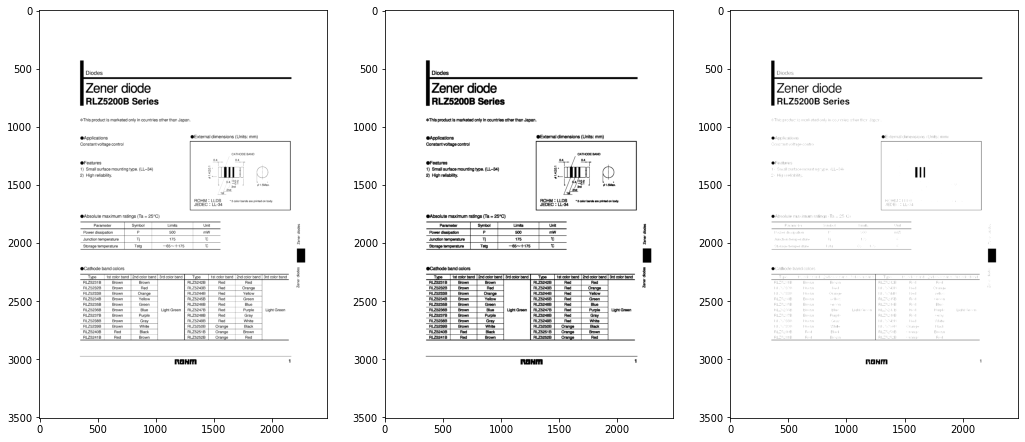

In [9]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3 
                        , figsize=(img_cv.shape[0]/200, img_cv.shape[1]/200 ))
ax1.imshow( img_cv  ,cmap='gray')
ax2.imshow( erode(img_cv)  ,cmap='gray')
ax3.imshow( dilate(img_cv)  ,cmap='gray')
plt.show()

## Observation:
**The original image looks fine for OCR in this case** 
- Could try eroding with 3,3 filter later

In [10]:
# pip install --upgrade google-cloud-vision

In [11]:
!curl -H "apikey:141a09305188957" --form "file=@document-000-113188.in.000.png" --form "language=eng" --form "isOverlayRequired=true" https://api.ocr.space/Parse/Image

curl: (26) read function returned funny value


## Try with the Python API

In [12]:
import requests
def ocr_space( filename,overlay = True
              ,api_key = '141a09305188957', language = 'eng'):

  payload = {
      'isOverlayRequired' : overlay,
      'apikey': api_key,
      'language': language,
  }

  with open(filename, 'rb') as f:
    r = requests.post('https://api.ocr.space/parse/image',
                      files = {filename : f},
                      data = payload,
                      )
    return r.content.decode()

In [13]:
import json
# json_output = json.loads( ocr_space(TEMPLATES_DIR+'/document-000-113188.in.000.png', overlay= False))
# /content/data/Document_Dataset/templates/document-000-113188.in.000.png

In [27]:
list_of_documents = {}
for k in template_store.keys():
  json_output = json.loads( ocr_space(TEMPLATES_DIR+'/'+k
                    , overlay= False))
  document = json_output['ParsedResults'][0]['ParsedText']
  list_doc = document.split(' ')
  # print(list_doc)
  list_of_documents[k] = list_doc
  # with open( k+'.txt', "w") as text_file:
  #   text_file.write(document)
print(list_of_documents)

{'document-001-118758.in.000.png': ['50/0', 'TOLERANCE\r\nSOT-323', 'CASE\r\nABSOLUTE', 'MAXIMUM', 'RATINGS\r\nPower', 'Dissipation', '(@', 'TA=250C)\r\nOperating', 'and', 'Storage', 'Temperature\r\nThermal', 'Resistance\r\nCMSZ5221', 'B\r\nTHRU\r\nCMSZ5261', 'B\r\n250', 'mw', 'ZENER', 'DIODE\r\n2.4\r\n1.0\r\n2.5\r\n1.0\r\n2.7\r\n1.0\r\n2.8\r\n1.0\r\n3.0\r\n1.0\r\n3.3\r\n1.0\r\n3.6\r\n1.0\r\n3.9\r\n1.0\r\n4.3\r\n1.0\r\n2.0\r\n2.0\r\n5.6\r\n3.0\r\n6.0\r\n3.5\r\n6.2\r\n4.0\r\n6.8\r\n5.0\r\n7.5\r\n6.0\r\n8.2\r\n6.5\r\n8.7\r\n6.5\r\n7.0\r\n8.0\r\nCentral\r\nSemiconductor', 'Corp.\r\nDESCRIPTION:\r\nThe', 'CENTRAL', 'SEMICONDUCTOR\r\nCMSZ5221B', 'Series', 'Silicon', 'Zener', 'Diode', 'is', 'a\r\nhigh', 'quality', 'voltage', 'regulator', 'for', 'use', 'in\r\nindustrial,', 'commercial,', 'entertainment', 'and\r\ncomputer', 'applications.', 'Higher', 'voltage', 'devices\r\nare', 'available', 'on', 'special', 'order.\r\nSYMBOL\r\nOJA\r\n250\r\n-65', 'to', '+', '175\r\n500\r\nUNITS\r\nOC/W\r\nEL

In [15]:
# !pip install gensim --upgrade

In [16]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [17]:
!python --version

Python 3.7.10


In [18]:
import gensim
gensim.__version__

'3.6.0'

In [21]:
import os
# txt_list = [ x for x in os.listdir('/content/') if '.txt' in x]
# documents = [ TaggedDocument(doc, [i]) for i, doc in enumerate( txt_list ) ]
# documents
documents = [ TaggedDocument(doc, [i]) for i, doc in enumerate( list_of_documents ) ]
documents

[TaggedDocument(words=['50/0', 'TOLERANCE\r\nSOT-323', 'CASE\r\nABSOLUTE', 'MAXIMUM', 'RATINGS\r\nPower', 'Dissipation', '(@', 'TA=250C)\r\nOperating', 'and', 'Storage', 'Temperature\r\nThermal', 'Resistance\r\nCMSZ5221', 'B\r\nTHRU\r\nCMSZ5261', 'B\r\n250', 'mw', 'ZENER', 'DIODE\r\n2.4\r\n1.0\r\n2.5\r\n1.0\r\n2.7\r\n1.0\r\n2.8\r\n1.0\r\n3.0\r\n1.0\r\n3.3\r\n1.0\r\n3.6\r\n1.0\r\n3.9\r\n1.0\r\n4.3\r\n1.0\r\n2.0\r\n2.0\r\n5.6\r\n3.0\r\n6.0\r\n3.5\r\n6.2\r\n4.0\r\n6.8\r\n5.0\r\n7.5\r\n6.0\r\n8.2\r\n6.5\r\n8.7\r\n6.5\r\n7.0\r\n8.0\r\nCentral\r\nSemiconductor', 'Corp.\r\nDESCRIPTION:\r\nThe', 'CENTRAL', 'SEMICONDUCTOR\r\nCMSZ5221B', 'Series', 'Silicon', 'Zener', 'Diode', 'is', 'a\r\nhigh', 'quality', 'voltage', 'regulator', 'for', 'use', 'in\r\nindustrial,', 'commercial,', 'entertainment', 'and\r\ncomputer', 'applications.', 'Higher', 'voltage', 'devices\r\nare', 'available', 'on', 'special', 'order.\r\nSYMBOL\r\nOJA\r\n250\r\n-65', 'to', '+', '175\r\n500\r\nUNITS\r\nOC/W\r\nELECTRICAL', 'C

In [25]:
model = Doc2Vec(documents, vector_size=200, window=1
                , min_count=1, workers=4, epochs=100)

In [28]:
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [29]:
model.save('/content/data/doc2vec_model_train')

In [30]:
loaded_model = Doc2Vec.load('/content/data/doc2vec_model_train')

In [ ]:
vector = loaded_model.infer_vector( doc_words = '/content/document-002-114195.out.000.png.txt')

TypeError: ignored

In [ ]:
with open('/content/document-000-113188.in.000.png.txt') as f:
    contents = f.read().split()

print(contents)

['Diodes', 'Zener', 'diode', 'RLZ5200B', 'Series', '*This', 'product', 'is', 'marketed', 'only', 'in', 'countries', 'other', 'than', 'Japan.', 'ROHM', ':', 'LLDS', "'Applications", 'Constant', 'voltage', 'control', "'Features", '1)', 'Small', 'surface', 'mounting', 'type.', '(LL—34)', "'External", 'dimensions', '(Units:', 'mm)', '2)', 'High', 'reliability.', "'Absolute", 'maximum', 'ratings', '(Ta', '0.4', '+1', 'JEDEC', ':', '1st', 'CATHODE', 'BAND', '0.4', '—0.1', '1.5Max.', '3rd', '2nd', '*', '3', 'color', 'bands', 'are', 'printed', 'on', 'body.', '=', '250C)', 'Parameter', 'Power', 'dissipation', 'Junction', 'temperature', 'Storage', 'temperature', "'Cathode", 'band', 'colors', 'Type', '1st', 'color', 'band', 'RLZ5231B', 'RLZ5232B', 'RLZ5233B', 'RLZ5234B', 'RLZ5235B', 'RLZ5236B', 'RLZ5237B', 'RLZ5238B', 'RLZ5239B', 'RLZ5240B', 'RLZ5241B', 'Brown', 'Brown', 'Brown', 'Brown', 'Brown', 'Brown', 'Brown', 'Brown', 'Brown', 'Red', 'Red', 'Symbol', '2nd', 'color', 'band', 'Brown', 'Red', 

In [ ]:
vector_string = loaded_model.infer_vector( doc_words= contents)

In [ ]:
vector_string.shape, vector.shape

((200,), (200,))

In [ ]:
vectors_train = { doc[0].replace('.txt','') : model.infer_vector(doc[0]).tolist()
 for  doc in documents }

In [ ]:
# import numpy as np
# distances = [ np.linalg.norm(vector-vec) for vec in vectors_train] #L2( Euclidean distance)
# np.argmin(distances)
# this is correct

## Store the document embeddings in corresponding template_store

In [ ]:
# json_string = json.dumps(vectors_train, indent=4)

In [ ]:
# vectors_train
with open('/content/data/vectors_train.json', "w") as outfile: 
    json.dump(vectors_train, outfile)